In [1]:
import requests
import time
import pandas as pd
import numpy as np
import psycopg2
import sqlalchemy
from dotenv import load_dotenv
import os

load_dotenv()

True

### Verbindung zur Datenbank aufbauen und Daten aus der Tabelle laden

In [2]:
host = os.getenv('HOST')
port = os.getenv('PORT')
user = os.getenv('USER')
password = os.getenv('PASSWORD')
database= os.getenv('DATABASE')

In [3]:
# Verbindung zur Datenbank herstellen
connection = psycopg2.connect(host=host, port=port, database=database, user=user, password=password)
print("Verbindung zur Datenbank erfolgreich hergestellt.")

# Einen Cursor erstellen, um SQL-Abfragen auszuführen
cursor = connection.cursor()

# SQL SELECT-Abfrage
select_query = "SELECT * FROM value;"

# Abfrage ausführen
cursor.execute(select_query)

# Ergebnis abrufen
rows = cursor.fetchall()

# Ergebnis in ein Pandas DataFrame umwandeln
df = pd.DataFrame(rows, columns=[desc[0] for desc in cursor.description])

# Cursor und Verbindung schließen
cursor.close()
connection.close()


Verbindung zur Datenbank erfolgreich hergestellt.


In [4]:
# Sicherstellen, dass 'time' als Datetime-Objekt erkannt wird
df['time'] = pd.to_datetime(df['time'])

### Random Forest Modell

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


# 1. Convert the time column to datetime objects
df['time'] = pd.to_datetime(df['time'])

# 2. Feature Engineering with Lags
lags = [1, 2, 3]  # Lags for 10, 20, and 30 minutes
for lag in lags:
    df[f'Temperatur_lag_{lag*10}'] = df.groupby('senseid_fk')['temperature'].shift(lag)

# 3. Create target variables for each prediction horizon
for minutes in [10, 20, 30]:
    shift = minutes // 10  # Calculate the shift based on 10-minute intervals
    df[f'Temperatur_in_{minutes}_Minuten'] = df.groupby('senseid_fk')['temperature'].shift(-shift)

# 4. Remove rows with missing values (introduced by lagging and shifting)
df.dropna(inplace=True)

In [8]:
# 5. Define target variables and create a dictionary for models
target_variables = ['Temperatur_in_10_Minuten', 'Temperatur_in_20_Minuten', 'Temperatur_in_30_Minuten']
models = {}

# 6. Train and evaluate models for each target variable
for target in target_variables:
    # 6.1. Select features and target variable
    X = df.drop(target_variables + ["time", "senseid_fk"], axis=1)
    y = df[target]

    # 6.2. Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 6.3. Create and train the Random Forest model
    model = RandomForestRegressor(n_estimators=400,max_depth=40, random_state=42)
    model.fit(X_train, y_train)

    # 6.4. Make predictions and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"\n{target}:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")

    # 6.5. Store the trained model
    models[target] = model


Temperatur_in_10_Minuten:
  Mean Squared Error: 0.6959775182910382
  Mean Absolute Error: 0.29405328315365437

Temperatur_in_20_Minuten:
  Mean Squared Error: 1.1561430452437964
  Mean Absolute Error: 0.42871305138224786

Temperatur_in_30_Minuten:
  Mean Squared Error: 1.5624276179679655
  Mean Absolute Error: 0.5264186126191158


### Mit GridSearch und CV

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# # 5. Define target variables and create a dictionary for models
# target_variables = ['Temperatur_in_10_Minuten', 'Temperatur_in_20_Minuten', 'Temperatur_in_30_Minuten']
# models = {}

# # Hyperparameter grid for Random Forest
# param_grid = {
#     'n_estimators': [300, 400],
#     'max_depth': [30, 40, 50, 60, 70],
# }

# # 6. Train and evaluate models for each target variable
# for target in target_variables:
#     # 6.1. Select features and target variable
#     X = df.drop(target_variables + ["time", "senseid_fk"], axis=1)
#     y = df[target]

#     # 6.2. Split data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # 6.3. Perform GridSearchCV to find the best hyperparameters
#     rf = RandomForestRegressor(random_state=42)
#     grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
#     grid_search.fit(X_train, y_train)

#     # 6.4. Get the best model from grid search
#     best_model = grid_search.best_estimator_

#     # 6.5. Make predictions and evaluate
#     y_pred = best_model.predict(X_test)
#     mse = mean_squared_error(y_test, y_pred)
#     mae = mean_absolute_error(y_test, y_pred)
#     print(f"\n{target}:")
#     print(f"  Best Parameters: {grid_search.best_params_}")
#     print(f"  Mean Squared Error: {mse}")
#     print(f"  Mean Absolute Error: {mae}")

#     # 6.6. Store the trained model
#     models[target] = best_model



Temperatur_in_10_Minuten:
  Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  Mean Squared Error: 0.7231009365555813
  Mean Absolute Error: 0.29696808916272927

Temperatur_in_20_Minuten:
  Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  Mean Squared Error: 1.1219574791632885
  Mean Absolute Error: 0.4293155597508828

Temperatur_in_30_Minuten:
  Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  Mean Squared Error: 1.3734161227737929
  Mean Absolute Error: 0.5241237983584991


### ARIMA

In [5]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [6]:
df.head()

,index,time,temperature,luftfeuchtigkeit,pm10,pm2_5,senseid_fk
0,1,2024-05-15 16:32:38,18.30,99.90,3.40,3.10,5ae4a726223bd80019a367a6
1,2,2024-05-15 16:32:39,17.90,75.63,9.45,8.20,5dde9523ba7944001da4150e
2,3,2024-05-15 16:32:40,22.90,55.90,3.23,2.93,5c08379b1c28f9001a3f580c
3,4,2024-05-15 16:32:40,17.24,69.30,10.77,3.38,5b4d11485dc1ec001b5452c7
4,5,2024-05-15 16:32:41,26.30,30.70,0.00,0.00,65e8d93acbf5700007f920ca


In [39]:
# Daten für eine Wetterstation extrahieren
station_id = "5ae4a726223bd80019a367a6" 
station_data = df[df['senseid_fk'] == station_id]

# Sortieren nach Zeit
station_data = station_data.sort_values(by='time')

station_data.drop(columns=['senseid_fk'], inplace=True)

In [40]:
# Erstelle eine neue Spalte 'date' für das Datum
station_data['date'] = station_data['time'].dt.date

# Gruppiere nach 'date' und berechne den Durchschnitt
daily_average = station_data.groupby('date').mean().reset_index()

# Falls 'index' nicht mehr benötigt wird
daily_average.drop(columns=['index'], inplace=True)

In [41]:
daily_average.head()

,date,time,temperature,luftfeuchtigkeit,pm10,pm2_5
0,2023-01-14,2023-01-14 18:43:20.670726656,10.514453,99.900000,1.732187,0.665586
1,2023-01-15,2023-01-15 12:00:21.312506112,6.525744,99.900000,4.233117,0.870946
2,2023-01-16,2023-01-16 11:59:47.438309888,5.091725,99.900000,3.442570,1.277852
3,2023-01-17,2023-01-17 12:03:14.077237504,2.712914,99.900000,9.385567,4.989825
4,2023-01-18,2023-01-18 12:00:31.452937472,1.000697,99.731533,12.459774,6.933990


In [42]:
# # Zeit und Temperatur als Zeitreihe
daily_average.set_index('time', inplace=True)
temperature_series = daily_average['temperature']

<Axes: xlabel='time'>

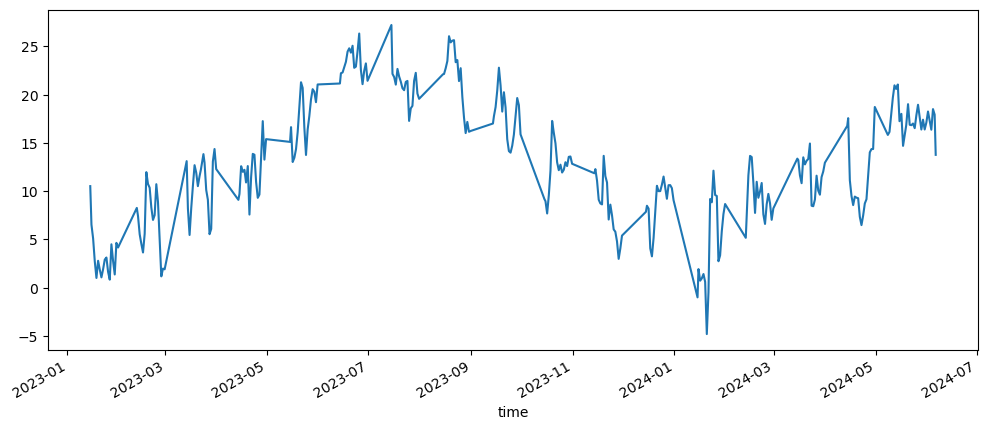

In [43]:
daily_average['temperature'].plot(figsize=(12,5))

In [44]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(daily_average['temperature'])

1. ADF :  -2.54527947566803
2. P-Value :  0.10484231961141982
3. Num Of Lags :  3
4. Num Of Observations Used For ADF Regression: 315
5. Critical Values :
	 1% :  -3.451281394993741
	 5% :  -2.8707595072926293
	 10% :  -2.571682118921643


Order für ARIMA

In [45]:
from pmdarima import auto_arima

In [46]:
stepwise_fit = auto_arima(daily_average['temperature'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1438.819, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1457.287, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1459.272, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1459.267, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1455.293, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1438.591, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1451.430, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1442.540, Time=0.31 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1436.316, Time=0.32 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1435.223, Time=0.15 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=1436.655, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=1438.101, Time=0.49 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1433.453, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1449.483, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  319
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -712.727
Date:                Thu, 06 Jun 2024   AIC                           1433.453
Time:                        09:13:19   BIC                           1448.501
Sample:                             0   HQIC                          1439.463
                                - 319                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0832      0.054     -1.553      0.120      -0.188       0.022
ma.L2         -0.2080      0.049     -4.277      0.000      -0.303      -0.113
ma.L3         -0.2362      0.054     -4.372      0.000      -0.342      -0.130
sigma2         5.1736      0.291     17.794      0.000       4.604       5.743
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                88.85
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.06
Prob(H) (two-sided):                  0.56   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
from statsmodels.tsa.arima.model import ARIMA

In [47]:
train=daily_average.iloc[:-30]
test=daily_average.iloc[-30:]
print(train.shape,test.shape)


(289, 5) (30, 5)


In [56]:
model=ARIMA(train["temperature"],order=(5,1,2))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            temperature   No. Observations:                  289
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -644.858
Date:                Thu, 06 Jun 2024   AIC                           1305.715
Time:                        09:14:48   BIC                           1335.019
Sample:                             0   HQIC                          1317.458
                                - 289                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6799      0.055     12.297      0.000       0.572       0.788
ar.L2         -1.0346      0.069    -14.920      0.000      -1.171      -0.899
ar.L3         -0.1527      0.090     -1.694      0.090      -0.329       0.024
ar.L4         -0.0342      0.075     -0.456      0.648      -0.181       0.112
ar.L5         -0.1520      0.063     -2.415      0.016      -0.275      -0.029
ma.L1         -0.7574      0.021    -35.707      0.000      -0.799      -0.716
ma.L2          0.9883      0.040     25.017      0.000       0.911       1.066
sigma2         5.0032      0.315     15.881      0.000       4.386       5.621
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               106.07
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.25
Prob(H) (two-sided):                  0.46   Kurtosis:                         5.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='time'>

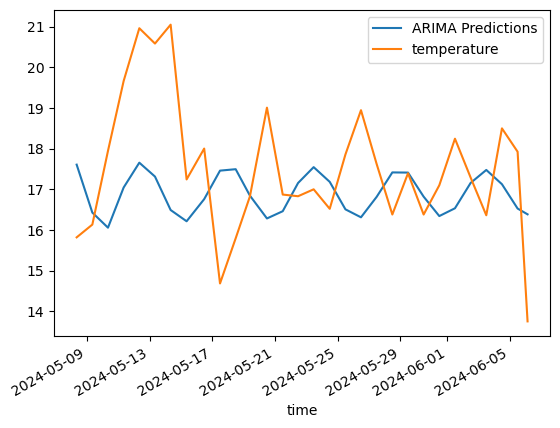

In [57]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.index=daily_average.index[start:end+1]
pred.plot(legend=True)
test['temperature'].plot(legend=True)


In [58]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['temperature'].mean()
rmse=sqrt(mean_squared_error(pred,test['temperature']))
print(rmse)

1.860032093906667


In [59]:
daily_average.temperature.mean()

12.950460933869774

### FÜR ARIMA SOLLTEN DIE DATEN AUF STUNDENEBENE ODER VLLT SOGAR TAGESEBENE REDUZIERT WERDEN